In [1]:
import pandas as pd
import networkx as nx
import itertools

In [2]:

file_path = 'Liguori_translations_FR_normalized_publishers_translators_places.xlsx'
df = pd.read_excel(file_path)

In [3]:
import math

In [4]:

G_1826_38 = nx.MultiDiGraph()

# Function to extract and sort years chronologically
def extract_years(row, cutoff_year0, cutoff_year1):
    year = row['First ed.']
    subsequent = row['Subsq. ed.']
    
    # Extract and filter years based on the cutoff year
    all_years = []
    
    if not math.isnan(year) and int(year) > cutoff_year0 and int(year) <= cutoff_year1:
    #if isinstance(year, (int, float)) and year < cutoff_year:
        all_years.append(int(year))
    
    if isinstance(subsequent, str):
        #subsequent_years = [int(x.split()[0]) for x in subsequent.split(',') if not (math.isnan(x) or not int(x.split()[0]) <= cutoff_year) else None]
        subsequent_years = [
            int(x.split()[0]) for x in subsequent.split(',')
            if x.strip() and not math.isnan(float(x.split()[0])) and cutoff_year0 < int(x.split()[0]) and int(x.split()[0]) <= cutoff_year1
            ]
        all_years.extend(subsequent_years)

    all_years = sorted(all_years)
    
    return all_years


def is_valid_year(x):
    try:
        year_int = int(x)
        return 1825 < year_int and year_int <= 1838
    except ValueError:
        return False
    

filtered_df = df[df['First ed.'].apply(lambda x: x if not (math.isnan(x) or not is_valid_year(x)) else None).notna()]

unique_publishers = set()

for publishers in filtered_df['Normalized Publisher']:
    if isinstance(publishers, str):
        unique_publishers.update([publisher.strip() for publisher in publishers.split(';')])
    else:
        unique_publishers.update([publishers])

for publisher in unique_publishers:
    G_1826_38.add_node(publisher, publications=[])
    

for index, row in filtered_df.iterrows():
    title = row['Title']
    years = extract_years(row, 1825, 1838)
    editions = sum(1 for year in years) if years != [] else 0  # Calculate number of editions based on years after 1825 and before 1839
    publishers = [publisher.strip() for publisher in row['Normalized Publisher'].split('; ')] if isinstance(row['Normalized Publisher'], str) else [row['Normalized Publisher']]
    translator = row['Normalized Translator']
    places = [place.strip() for place in row['Publ. place'].split('; ')] if isinstance(row['Publ. place'], str) else [str(row['Publ. place']).strip()]

    for publisher in unique_publishers:
        if publisher in publishers:
            G_1826_38.nodes[publisher]['publications'].append({
                'title': title,
                'years': years,
                'editions': [editions],
                'publisher': publishers,
                'translator': translator,
                'place': places
            })


for publisher in G_1826_38.nodes():
    if 'publications' in G_1826_38.nodes[publisher]:  # Check if 'publications' key exists
        magnitude = sum(pub['editions'][0] for pub in G_1826_38.nodes[publisher]['publications'])
        G_1826_38.nodes[publisher]['magnitude'] = magnitude

In [5]:

len(G_1826_38.nodes)

79

In [10]:

nodes_with_sizes = [(publisher, data['magnitude']) for publisher, data in G_1826_38.nodes(data=True) if 'magnitude' in data]

sorted_nodes = sorted(nodes_with_sizes, key=lambda x: x[1], reverse=True)

for publisher, size in sorted_nodes:
    print(f"Publisher: {publisher}, Size: {size}")

Publisher: parent-desbarres, Size: 28
Publisher: bureau de la des livres de piété, Size: 25
Publisher: perisse, Size: 22
Publisher: sguin, Size: 18
Publisher: casterman, Size: 17
Publisher: gaume, Size: 10
Publisher: marietti, Size: 9
Publisher: lefort, Size: 9
Publisher: thibaud, Size: 7
Publisher: landriot, Size: 6
Publisher: joly, Size: 5
Publisher: association catholique du sacré-coeur, Size: 5
Publisher: lesne, Size: 4
Publisher: gauthier, Size: 4
Publisher: plagaud, Size: 4
Publisher: belon, Size: 3
Publisher: outheninchalandre, Size: 3
Publisher: caron, Size: 2
Publisher: crozet, Size: 2
Publisher: bthune, Size: 2
Publisher: nan, Size: 2
Publisher: laguerre, Size: 2
Publisher: dureau, Size: 2
Publisher: clermont librairie catholique, Size: 2
Publisher: sauvignet, Size: 2
Publisher: vitet, Size: 2
Publisher: pillot, Size: 2
Publisher: prudont, Size: 2
Publisher: librairie catholique, Size: 2
Publisher: prudhomme, Size: 2
Publisher: fricadeldubiez, Size: 2
Publisher: clermont, Siz

In [6]:

def add_edge_with_attributes(G, publisher_A, publisher_B, title, source_years, target_years,
                             source_translator, target_translator, source_num_editions,
                             target_num_editions, source_place, target_place, weight, relation, key):
    G.add_edge(publisher_A, publisher_B, title=title, source_years=source_years, target_years=target_years,
               source_translator=source_translator, target_translator=target_translator,
               source_num_editions=source_num_editions, target_num_editions=target_num_editions,
               source_place=source_place, target_place=target_place, weight=weight, relation=relation, key=key)

In [7]:
existing_edges = set()

# Function to add edges between publishers with support for multiple edges of the same type
def add_edges_between_publishers(G):
    for pub_A, pub_B in itertools.combinations(G.nodes, 2):  # Iterate over pairs of nodes
        publications_A = G.nodes[pub_A]['publications']
        publications_B = G.nodes[pub_B]['publications']
        
        # Compare all publications between two publishers
        for publication_A in publications_A:
            for publication_B in publications_B:
                title_A, title_B = publication_A['title'], publication_B['title']
                years_A, years_B = publication_A['years'], publication_B['years']
                editions_A, editions_B = publication_A['editions'], publication_B['editions']
                translators_A, translators_B = publication_A['translator'], publication_B['translator']
                publishers_A, publishers_B = set(publication_A['publisher']), set(publication_B['publisher'])
                
                # Ensure translators_A and translators_B are lists
                translators_A = translators_A if isinstance(translators_A, list) else []
                translators_B = translators_B if isinstance(translators_B, list) else []

                
                # Initialize edge counters
                edge_counter = 0

                # Check for copublication
                if (len(publishers_A) == 1 & len(publishers_B) == 1) and title_A == title_B and set(years_A) == set(years_B):
                    # Create a unique edge key
                    edge_counter = sum(1 for key in existing_edges if f"copub_{pub_A}_{pub_B}_" in key) + 1
                    edge_key = f"copub_{pub_A}_{pub_B}_{title_A}_{edge_counter}"

                    # Check if the edge already exists
                    if edge_key not in existing_edges:
                        weight = max(editions_A[0], editions_B[0])
                        add_edge_with_attributes(
                            G, pub_A, pub_B, title_A, years_A, years_B, translators_A, translators_B,
                            editions_A, editions_B, publication_A['place'], publication_B['place'],
                            weight, 'copublication', edge_key
                        )
                        existing_edges.add(edge_key)

                # Check for reprint relation
                if set(translators_A) == set(translators_B) and title_A == title_B and years_A and years_B:
                    if len(years_A) > 0 and len(years_B) > 0:
                        if years_A[0] < years_B[0] and publishers_A != publishers_B:
                            edge_counter += 1
                            edge_key = f"reprint_{pub_A}_{pub_B}_{title_A}_{edge_counter}"

                            # Check if the edge already exists
                            if edge_key not in existing_edges:
                                weight = editions_B[0]
                                add_edge_with_attributes(
                                    G, pub_A, pub_B, title_A, years_A, years_B, translators_A, translators_B,
                                    editions_A, editions_B, publication_A['place'], publication_B['place'],
                                    weight, 'reprint', edge_key
                                )
                                existing_edges.add(edge_key)

                # Check for retranslation relation
                if set(translators_A) != set(translators_B) and title_A == title_B and years_A and years_B:
                    if len(years_A) > 0 and len(years_B) > 0:
                        if years_A[0] < years_B[0] and publishers_A != publishers_B:
                            edge_counter += 1
                            edge_key = f"retrans_{pub_A}_{pub_B}_{title_A}_{edge_counter}"

                            # Check if the edge already exists
                            if edge_key not in existing_edges:
                                weight = editions_B[0]
                                add_edge_with_attributes(
                                    G, pub_A, pub_B, title_A, years_A, years_B, translators_A, translators_B,
                                    editions_A, editions_B, publication_A['place'], publication_B['place'],
                                    weight, 'retranslation', edge_key
                                )
                                existing_edges.add(edge_key)

In [8]:

add_edges_between_publishers(G_1826_38)

In [9]:
len(G_1826_38.edges)

657

In [11]:
len(existing_edges)

657

In [12]:

for title, first_ed, subsq_ed, edition, publisher, translator, place in zip(
        filtered_df['Title'],
        filtered_df['First ed.'],
        filtered_df['Subsq. ed.'],
        filtered_df['Editions'],
        filtered_df['Normalized Publisher'],
        filtered_df['Normalized Translator'],
        filtered_df['Publ. place']
    ):
    
    publisher_list = [pub.strip() for pub in str(publisher).split(';') if pub.strip()]
    
    translator_list = [trans.strip() for trans in str(translator).split(';') if trans.strip()]
    
    place_list = [pl.strip() for pl in str(place).split(';') if pl.strip()]
    
    if len(publisher_list) > 1:
        
        for pub_A, pub_B in itertools.combinations(publisher_list, 2):
            # Assign a weight based on editions
            weight = max(edition, edition)
            # Generate a unique edge key for each copublication instance
            edge_counter = sum(1 for key in existing_edges if f"copub_{pub_A}_{pub_B}_" in key) + 1
            edge_key = f"copub_{pub_A}_{pub_B}_{title}_{edge_counter}"

            # Check if the edge already exists
            if edge_key not in existing_edges:
                add_edge_with_attributes(
                    G_1826_38, pub_A, pub_B, title, [first_ed, subsq_ed], [first_ed, subsq_ed], translator_list, translator_list,
                    [edition], [edition], place_list, place_list, weight, 'copublication', edge_key
                )
                existing_edges.add(edge_key)


In [18]:

out_degrees = dict(G_1826_38.out_degree())
in_degrees = dict(G_1826_38.in_degree())
overall_degrees = {node: out_degrees.get(node, 0) + in_degrees.get(node, 0) for node in G_1826_38.nodes()}

nodes_by_out_degree = sorted(out_degrees, key=out_degrees.get, reverse=True)
nodes_by_in_degree = sorted(in_degrees, key=in_degrees.get, reverse=True)
nodes_by_overall_degree = sorted(overall_degrees, key=overall_degrees.get, reverse=True)

print("Nodes ordered by outgoing degree:")
for node in nodes_by_out_degree:
    print(node, out_degrees[node])

print("\nNodes ordered by incoming degree:")
for node in nodes_by_in_degree:
    print(node, in_degrees[node])

print("\nNodes ordered by overall degree:")
for node in nodes_by_overall_degree:
    print(node, overall_degrees[node])

Nodes ordered by outgoing degree:
petit 29
sainton 27
laguerre 26
adam 24
dureau 23
fischerjoly 22
vieusseux 22
beaucrusand 22
bousquetoffray 21
monnoyer 19
belon 18
chaillot 18
vannier 17
thiriot 16
denn 16
alzine 15
casterman 14
perisse 14
simon 13
ardant 11
outheninchalandre 10
sguin 10
ptri 10
joly 10
didier 9
belin 9
bureau de la des livres de piété 9
caron 8
sens 8
marietti 8
lesne 7
thibaud 7
prudont 7
plagaud 7
fischer 6
veysset 5
crozet 5
association catholique du sacré-coeur 5
gauthier 4
rusand 4
vitet 4
couanon 4
busseuil 4
bthune 3
paya 3
bricon 2
vial 2
popelain 2
clermont librairie catholique 2
landriot 2
aimburdet 1
mossy 1
nan 1
langlum 1
boissel 1
lefort 1
marquiset 1
prudhomme 1
clermont 0
guyot 0
escoffier 0
peltier 0
faguier 0
boget 0
offray 0
haener 0
gaume 0
ignon 0
van linthout 0
ponston 0
hoener 0
poussielguerusand 0
sauvignet 0
paravia 0
pillot 0
parent-desbarres 0
pouston 0
librairie catholique 0
fricadeldubiez 0

Nodes ordered by incoming degree:
fricadeldubi

In [19]:


weights = []

outgoing_weighted_degrees = {}
incoming_weighted_degrees = {}
overall_weighted_degrees = {}

for node in G_1826_38.nodes():
    successors = []
    for node_id in G_1826_38.successors(node):
        successors.append(node_id)
    weights = []
    for u, v, key, attr in G_1826_38.edges(keys=True, data=True):
        if (u in successors and v == node) or (u == node and v in successors):
            weight = attr['weight']
            #weights.append(sum(weight))
            weights.append(weight)
    #outgoing_weight = sum(sum(G11.edges[node, neighbor]['weight']) for neighbor in G11.successors(node))
    outgoing_weighted_degrees[node] = sum(weights)

for node in G_1826_38.nodes():
    predecessors = []
    for node_id in G_1826_38.predecessors(node):
        predecessors.append(node_id)
    weights = []
    for u, v, key, attr in G_1826_38.edges(keys=True, data=True):
        if (u in predecessors and v == node) or (u == node and v in predecessors):
            weight = attr['weight']
            # weights.append(sum(weight))
            weights.append(weight)
    #incoming_weight = sum(sum(G11.edges[neighbor, node]['weight']) for neighbor in G11.predecessors(node))
    incoming_weighted_degrees[node] = sum(weights)

for node in G_1826_38.nodes():
    overall_weighted_degree = outgoing_weighted_degrees.get(node, 0) + incoming_weighted_degrees.get(node, 0)
    overall_weighted_degrees[node] = overall_weighted_degree

sorted_outgoing_weighted_degrees = dict(sorted(outgoing_weighted_degrees.items(), key=lambda item: item[1], reverse=True))
sorted_incoming_weighted_degrees = dict(sorted(incoming_weighted_degrees.items(), key=lambda item: item[1], reverse=True))
sorted_overall_weighted_degrees = dict(sorted(overall_weighted_degrees.items(), key=lambda item: item[1], reverse=True))

print("Outgoing Weighted Degrees:", sorted_outgoing_weighted_degrees)
print("Incoming Weighted Degrees:", sorted_incoming_weighted_degrees)
print("Overall Weighted Degrees:", sorted_overall_weighted_degrees)

Outgoing Weighted Degrees: {'petit': 29, 'sainton': 27, 'laguerre': 26, 'adam': 24, 'dureau': 23, 'fischerjoly': 22, 'vieusseux': 22, 'beaucrusand': 22, 'bousquetoffray': 21, 'monnoyer': 19, 'belon': 18, 'chaillot': 18, 'vannier': 17, 'thibaud': 17, 'casterman': 16, 'perisse': 16, 'thiriot': 16, 'denn': 16, 'alzine': 15, 'simon': 13, 'lesne': 12, 'ardant': 11, 'caron': 10, 'outheninchalandre': 10, 'sguin': 10, 'ptri': 10, 'joly': 10, 'plagaud': 10, 'didier': 9, 'belin': 9, 'bureau de la des livres de piété': 9, 'sens': 8, 'marietti': 8, 'crozet': 7, 'fischer': 7, 'prudont': 7, 'vial': 6, 'veysset': 5, 'bthune': 5, 'vitet': 5, 'couanon': 5, 'association catholique du sacré-coeur': 5, 'gauthier': 4, 'rusand': 4, 'busseuil': 4, 'paya': 3, 'bricon': 2, 'popelain': 2, 'clermont librairie catholique': 2, 'landriot': 2, 'aimburdet': 1, 'mossy': 1, 'langlum': 1, 'boissel': 1, 'lefort': 1, 'marquiset': 1, 'prudhomme': 1, 'clermont': 0, 'guyot': 0, 'escoffier': 0, 'peltier': 0, nan: 0, 'faguier'

In [20]:

from collections import Counter


source_place_counter = Counter()
target_place_counter = Counter()
overall_place_counter = Counter()


for publisher_A, publisher_B, data in G_1826_38.edges(data=True):
    if isinstance(data['source_place'], list):
        source_places = data['source_place']
    else:
        source_places = [data['source_place']]
    if isinstance(data['target_place'], list):
        target_places = data['target_place']
    else:
        target_places = [data['target_place']]

    
    for i, place_list in enumerate(source_places):
        if isinstance(place_list, str):
            source_places[i] = [place_list]
    
    for i, place_list in enumerate(target_places):
        if isinstance(place_list, str):
            #place_list = [place_list]
            target_places[i] = [place_list]
            
    for place_list in source_places:
        for place in place_list:
            source_place_counter[place] += 1
            
    for place_list in target_places:
        for place in place_list:
            target_place_counter[place] += 1
    
    for place_list in source_places + target_places:
        #if isinstance(place_list, str):
            #place_list = [place_list]  # Convert string to list
        for place in place_list:
            overall_place_counter[place] += 1


sorted_source_places = source_place_counter.most_common()
sorted_target_places = target_place_counter.most_common()
sorted_overall_places = overall_place_counter.most_common()


print("Sorted Source Places:", sorted_source_places)
print("Sorted Target Places:", sorted_target_places)
print("Sorted Overall Places:", sorted_overall_places)

Sorted Source Places: [('Paris', 90), ('Avignon', 81), ('Le Mans', 60), ('Lyon', 40), ('Besançon', 40), ('Toulouse', 33), ('Troyes', 27), ('Bar-le-Duc', 26), ('Clermont', 25), ('Vire', 24), ('Fougères', 21), ('Perpignan', 15), ('Tournai', 14), ('Baume', 13), ('Dôle', 13), ('Amiens', 12), ('Limoges', 11), ('Neufchateau', 10), ('Turin', 8), ('Nantes', 5), ('Digne', 3), ('Lons-le-Saunier', 2), ('Dijon', 2), ('Annecy', 1), ('Marseille', 1), ('Lille', 1), ('Saint-Brieuc', 1)]
Sorted Target Places: [('Clermont', 108), ('Paris', 86), ('Avignon', 57), ('Besançon', 43), ('Mirecourt', 43), ('Saint-Brieuc', 32), ('Toulouse', 30), ('Lyon', 26), ('Dôle', 24), ('Dijon', 21), ('Le Mans', 16), ('Bar-le-Duc', 13), ('Fougères', 11), ('Saint-Étienne', 10), ('Nantes', 10), ('Lille', 9), ('Neufchateau', 9), ('Perpignan', 7), ('Baume', 6), ('Saint Brieuc', 5), ('Amiens', 4), ('Limoges', 3), ('Digne', 3), ('Troyes', 1)]
Sorted Overall Places: [('Paris', 176), ('Avignon', 138), ('Clermont', 133), ('Besançon',

In [21]:

source_place_counter_weighted = Counter()
target_place_counter_weighted = Counter()
overall_place_counter_weighted = Counter()

for publisher_A, publisher_B, data in G_1826_38.edges(data=True):
    # Get the weight of the current edge
    weight = data['weight']
    
    if isinstance(data['source_place'], list):
        source_places = data['source_place']
    else:
        source_places = [data['source_place']]
    if isinstance(data['target_place'], list):
        target_places = data['target_place']
    else:
        target_places = [data['target_place']]

    for i, place_list in enumerate(source_places):
        if isinstance(place_list, str):
            source_places[i] = [place_list]

    for i, place_list in enumerate(target_places):
        if isinstance(place_list, str):
            target_places[i] = [place_list]

    for place_list in source_places:
        for place in place_list:
            # source_place_counter_weighted[place] += weight[0]
            source_place_counter_weighted[place] += weight
            
    for place_list in target_places:
        for place in place_list:
            # target_place_counter_weighted[place] += weight[0]
            target_place_counter_weighted[place] += weight

    for place_list in source_places + target_places:
        for place in place_list:
            # overall_place_counter_weighted[place] += weight[0]
            overall_place_counter_weighted[place] += weight

sorted_source_places_weighted = source_place_counter_weighted.most_common()
sorted_target_places_weighted = target_place_counter_weighted.most_common()
sorted_overall_places_weighted = overall_place_counter_weighted.most_common()

print("Sorted Source Places (Weighted):", sorted_source_places_weighted)
print("Sorted Target Places (Weighted):", sorted_target_places_weighted)
print("Sorted Overall Places (Weighted):", sorted_overall_places_weighted)

Sorted Source Places (Weighted): [('Paris', 96), ('Avignon', 82), ('Le Mans', 60), ('Lyon', 49), ('Besançon', 40), ('Clermont', 35), ('Toulouse', 33), ('Troyes', 27), ('Bar-le-Duc', 26), ('Vire', 24), ('Fougères', 22), ('Tournai', 16), ('Amiens', 15), ('Perpignan', 15), ('Baume', 13), ('Dôle', 13), ('Limoges', 11), ('Neufchateau', 10), ('Digne', 9), ('Turin', 8), ('Nantes', 5), ('Lons-le-Saunier', 2), ('Dijon', 2), ('Annecy', 1), ('Marseille', 1), ('Lille', 1), ('Saint-Brieuc', 1)]
Sorted Target Places (Weighted): [('Clermont', 125), ('Paris', 92), ('Avignon', 58), ('Besançon', 43), ('Mirecourt', 43), ('Lyon', 33), ('Saint-Brieuc', 32), ('Toulouse', 30), ('Dôle', 24), ('Dijon', 21), ('Le Mans', 16), ('Bar-le-Duc', 13), ('Fougères', 12), ('Saint-Étienne', 10), ('Nantes', 10), ('Lille', 9), ('Digne', 9), ('Neufchateau', 9), ('Perpignan', 7), ('Baume', 6), ('Saint Brieuc', 5), ('Amiens', 4), ('Limoges', 3), ('Troyes', 1)]
Sorted Overall Places (Weighted): [('Paris', 188), ('Clermont', 160

In [60]:

# Initialize counters for unweighted and weighted titles
unweighted_title_counter = Counter()
weighted_title_counter = Counter()

# Initialize dictionaries to store concatenated source and target places for each title
title_source_places = {}
title_target_places = {}

# Iterate over edges in the graph
for publisher_A, publisher_B, data in G_thru_1825.edges(data=True):
    title = data['title']
    weight = data['weight']
    
    # Increment the unweighted and weighted title counters
    unweighted_title_counter[title] += 1
    weighted_title_counter[title] += weight
    
    if isinstance(data['source_place'], list):
        source_places = data['source_place']
    else:
        source_places = [data['source_place']]
    if isinstance(data['target_place'], list):
        target_places = data['target_place']
    else:
        target_places = [data['target_place']]

    for i, place_list in enumerate(source_places):
        if isinstance(place_list, str):
            source_places[i] = [place_list]

    for i, place_list in enumerate(target_places):
        if isinstance(place_list, str):
            target_places[i] = [place_list]
    
    if title not in title_source_places:
                title_source_places[title] = [] 
            
    for place_list in source_places:
        for place in place_list:
            title_source_places[title].append(place)
    
    if title not in title_target_places:
                title_target_places[title] = [] 
            
    for place_list in target_places:
        for place in place_list:          
            title_target_places[title].append(place)

# Sort titles based on unweighted occurrences
sorted_unweighted_titles = unweighted_title_counter.most_common()

# Sort titles based on weighted occurrences
sorted_weighted_titles = weighted_title_counter.most_common()

for elem in sorted_unweighted_titles:
    print(f"Title and number of connections between places it occasioned: {elem} | Source Places: {set(title_source_places[elem[0]])} | Target Places: {set(title_target_places[elem[0]])}")

for ele in sorted_weighted_titles:
    print(f"Title and weighted number of connections between places it occasioned: {ele} | Source Places: {set(title_source_places[ele[0]])} | Target Places: {set(title_target_places[ele[0]])}")

Title and number of connections between places it occasioned: ('Visite au S. Sacrement et à\xa0 la Sainte Vierge', 381) | Source Places: {'Toulouse', 'Avignon', 'Saumur', 'Amiens', 'Nantes', 'Besançon', 'Lille', 'Angers', 'Lyon', 'Montbéliard', 'Malines', 'Saint-Dié', 'Paris', 'Dôle', 'Fougères', 'Vannes'} | Target Places: {'Toulouse', 'Avignon', 'Amiens', 'Nantes', 'Besançon', 'Lille', 'Angers', 'Lyon', 'Montbéliard', 'Saint-Dié', 'Paris', 'Dôle', 'Fougères', 'Vannes'}
Title and number of connections between places it occasioned: ('Instruction sur le Chemin de La Croix, avec les pratiques de cette dévotion, dédiée à la Très-Sainte Vierge', 92) | Source Places: {'Brest', 'Gand [Ghent]', 'Avignon', 'Nantes', 'Orléans', 'Lille', 'Lyon', 'Paris', 'Nancy'} | Target Places: {'Valence', 'Brest', 'Bayonne', 'Paris', 'Avignon', 'Nantes', 'Châteauroux', 'Orléans', 'Lille', 'Lyon', 'Aurillac'}
Title and weighted number of connections between places it occasioned: ('Visite au S. Sacrement et à\xa

In [13]:


G_combined = nx.DiGraph()

for u, v, key, attr in G_1826_38.edges(keys=True, data=True):
    weight = attr.get('weight', 0)  # Default to 0 if 'weight' is missing

    if G_combined.has_edge(u, v):
        G_combined[u][v]['weight'] += weight
    else:
        G_combined.add_edge(u, v, weight=weight)

for node, data in G_1826_38.nodes(data=True):
    if not G_combined.has_node(node):
        G_combined.add_node(node, **data)

In [14]:

len(G_combined.nodes)

79

In [15]:
len(G_combined.edges) # out of 657 edges in G_1826_38 

618

In [25]:

closeness_centralities = nx.closeness_centrality(G_combined)

betweenness_centralities = nx.betweenness_centrality(G_combined)

In [26]:

eigenvector_centralities = nx.eigenvector_centrality(G_combined)

In [85]:
# eigenvector_centralities = nx.eigenvector_centrality(G_combined, max_iter = 500)

In [27]:
import operator

In [28]:

sorted_closeness = sorted(closeness_centralities.items(), key=operator.itemgetter(1), reverse=True)
sorted_betweenness = sorted(betweenness_centralities.items(), key=operator.itemgetter(1), reverse=True)
sorted_eigenvector = sorted(eigenvector_centralities.items(), key=operator.itemgetter(1), reverse=True)

In [29]:
sorted_closeness

[('fricadeldubiez', 0.49846153846153846),
 ('marquiset', 0.4748858447488584),
 ('thibaud', 0.41103341103341107),
 ('bureau de la des livres de piété', 0.40221216691804923),
 ('prudhomme', 0.4017818339852238),
 ('landriot', 0.3988804622607439),
 ('pouston', 0.28861061419200956),
 ('sguin', 0.28492935635792777),
 ('lefort', 0.2822039072039072),
 ('plagaud', 0.2693764568764569),
 ('librairie catholique', 0.26688723462917013),
 ('prudont', 0.2508361204013378),
 ('association catholique du sacré-coeur', 0.24931318681318682),
 ('popelain', 0.23567119155354452),
 ('pillot', 0.21034332898739677),
 ('joly', 0.1995841995841996),
 ('paya', 0.18803418803418803),
 ('lesne', 0.18376068376068377),
 ('crozet', 0.18376068376068377),
 ('langlum', 0.18250377073906487),
 ('didier', 0.18250377073906487),
 ('sens', 0.17728937728937727),
 ('busseuil', 0.17728937728937727),
 ('couanon', 0.1766826923076923),
 ('belin', 0.16770616770616772),
 ('ptri', 0.166289592760181),
 ('fischer', 0.16329284750337383),
 ('du

In [30]:

sorted_betweenness 

[('laguerre', 0.025391275391275392),
 ('bureau de la des livres de piété', 0.025044400044400048),
 ('vannier', 0.017982017982017984),
 ('plagaud', 0.016927516927516928),
 ('couanon', 0.016150516150516152),
 ('dureau', 0.012071262071262072),
 ('perisse', 0.011072261072261072),
 ('sguin', 0.007867132867132868),
 ('joly', 0.007672882672882673),
 ('prudont', 0.00627150627150627),
 ('bthune', 0.003996003996003996),
 ('thibaud', 0.0023587523587523585),
 ('association catholique du sacré-coeur', 0.002289377289377289),
 ('lesne', 0.0020535020535020535),
 ('crozet', 0.0019147519147519148),
 ('gauthier', 0.0014985014985014985),
 ('langlum', 0.001332001332001332),
 ('landriot', 0.0011932511932511933),
 (nan, 0.0001665001665001665),
 ('lefort', 8.325008325008325e-05),
 ('caron', 0.0),
 ('offray', 0.0),
 ('pouston', 0.0),
 ('vitet', 0.0),
 ('bricon', 0.0),
 ('casterman', 0.0),
 ('gaume', 0.0),
 ('pillot', 0.0),
 ('librairie catholique', 0.0),
 ('belon', 0.0),
 ('veysset', 0.0),
 ('ardant', 0.0),
 (

In [31]:
sorted_eigenvector

[('fricadeldubiez', 0.7163564103625311),
 ('marquiset', 0.43154015943383306),
 ('prudhomme', 0.23518909488935572),
 ('landriot', 0.22873348773159333),
 ('librairie catholique', 0.21828587443597555),
 ('thibaud', 0.17216183178301905),
 ('plagaud', 0.16973469071829944),
 ('pouston', 0.1402111637817223),
 ('bureau de la des livres de piété', 0.12846204548990775),
 ('crozet', 0.10347456610629843),
 ('lefort', 0.09824221198672643),
 ('pillot', 0.09090258137386845),
 ('lesne', 0.07250445838651781),
 ('association catholique du sacré-coeur', 0.06467505883193057),
 ('sguin', 0.05607056594178445),
 ('popelain', 0.043727288761858545),
 ('prudont', 0.03683124258519107),
 ('joly', 0.03683124258519105),
 ('couanon', 0.02834640517246933),
 ('busseuil', 0.02834640517246933),
 ('didier', 0.020115845160338507),
 ('sens', 0.020115845160338507),
 ('belin', 0.019861567759747612),
 ('fischer', 0.019861567759747612),
 ('ptri', 0.019861567759747612),
 ('paya', 0.015038736453767854),
 ('langlum', 0.0150387364

In [32]:

weighted_closeness = nx.closeness_centrality(G_combined, distance='weight')
weighted_betweenness = nx.betweenness_centrality(G_combined, weight='weight')
weighted_eigenvector = nx.eigenvector_centrality(G_combined, max_iter = 500, weight='weight')

sorted_weighted_closeness = sorted(weighted_closeness.items(), key=lambda x: x[1], reverse=True)
sorted_weighted_betweenness = sorted(weighted_betweenness.items(), key=lambda x: x[1], reverse=True)
sorted_weighted_eigenvector = sorted(weighted_eigenvector.items(), key=lambda x: x[1], reverse=True)

In [33]:

sorted_weighted_closeness

[('marquiset', 0.43881856540084385),
 ('fricadeldubiez', 0.42482517482517484),
 ('prudhomme', 0.34355258268301747),
 ('bureau de la des livres de piété', 0.3308519437551695),
 ('thibaud', 0.32684584491813407),
 ('plagaud', 0.2604959143420682),
 ('pouston', 0.2558815754692043),
 ('lefort', 0.24188906331763477),
 ('prudont', 0.23547880690737835),
 ('sguin', 0.2326923076923077),
 ('association catholique du sacré-coeur', 0.2326923076923077),
 ('landriot', 0.22839123242349046),
 ('librairie catholique', 0.2085757379875027),
 ('popelain', 0.20032051282051283),
 ('joly', 0.18934911242603553),
 ('couanon', 0.1766826923076923),
 ('busseuil', 0.17236467236467237),
 ('ptri', 0.16153846153846152),
 ('didier', 0.15910585141354372),
 ('belin', 0.15910585141354372),
 ('pillot', 0.15809243834721542),
 ('paya', 0.15512820512820513),
 ('langlum', 0.15512820512820513),
 ('sens', 0.15512820512820513),
 ('fischer', 0.15512820512820513),
 ('peltier', 0.13840920983778127),
 ('crozet', 0.13545787545787547),


In [34]:

sorted_weighted_betweenness

[('laguerre', 0.02596381792810364),
 ('bureau de la des livres de piété', 0.024793042430919263),
 ('plagaud', 0.019394890823462255),
 ('vannier', 0.018148518148518148),
 ('couanon', 0.01640123582482694),
 ('dureau', 0.012400181517828578),
 ('perisse', 0.011072261072261072),
 ('joly', 0.00944152886511998),
 ('prudont', 0.007868102291693402),
 ('sguin', 0.006983745500743207),
 ('crozet', 0.004376575805147233),
 ('bthune', 0.003996003996003996),
 ('association catholique du sacré-coeur', 0.0020822215058126205),
 ('gauthier', 0.0014985014985014985),
 ('thibaud', 0.0013343293805478677),
 ('langlum', 0.001332001332001332),
 ('landriot', 0.0008348288810473685),
 ('lesne', 0.000333000333000333),
 ('didier', 0.00026650475503093473),
 ('marquiset', 0.0002559609702466845),
 ('sens', 0.00025381902805949344),
 ('prudhomme', 0.0002485609628466771),
 (nan, 0.0001665001665001665),
 ('beaucrusand', 0.00016025641025641023),
 ('simon', 0.0001332001332001332),
 ('vitet', 0.00012487512487512488),
 ('belin'

In [35]:
sorted_weighted_eigenvector

[('landriot', 0.7733629563957847),
 ('fricadeldubiez', 0.37512334530447505),
 ('marquiset', 0.2854384460447479),
 ('crozet', 0.21860490486649786),
 ('lesne', 0.21265108890933548),
 ('librairie catholique', 0.17798912442393355),
 ('plagaud', 0.1354449173451669),
 ('thibaud', 0.1354401170587621),
 ('pillot', 0.13542165814510648),
 ('prudhomme', 6.942897802109097e-05),
 ('bureau de la des livres de piété', 5.6532541684321754e-05),
 ('pouston', 4.0982987008826525e-05),
 ('lefort', 2.9985340351012505e-05),
 ('sguin', 1.8390397109569205e-05),
 ('association catholique du sacré-coeur', 1.572628159395204e-05),
 ('popelain', 1.531688732580458e-05),
 ('joly', 1.1506186846481813e-05),
 ('prudont', 9.496907192219277e-06),
 ('couanon', 7.487627537956737e-06),
 ('busseuil', 7.487627537956737e-06),
 ('didier', 6.659292780526152e-06),
 ('sens', 6.659292780526152e-06),
 ('paya', 6.5234543198193836e-06),
 ('vannier', 5.492436037330203e-06),
 ('belin', 5.478347883694199e-06),
 ('fischer', 5.4783478836941

In [16]:

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

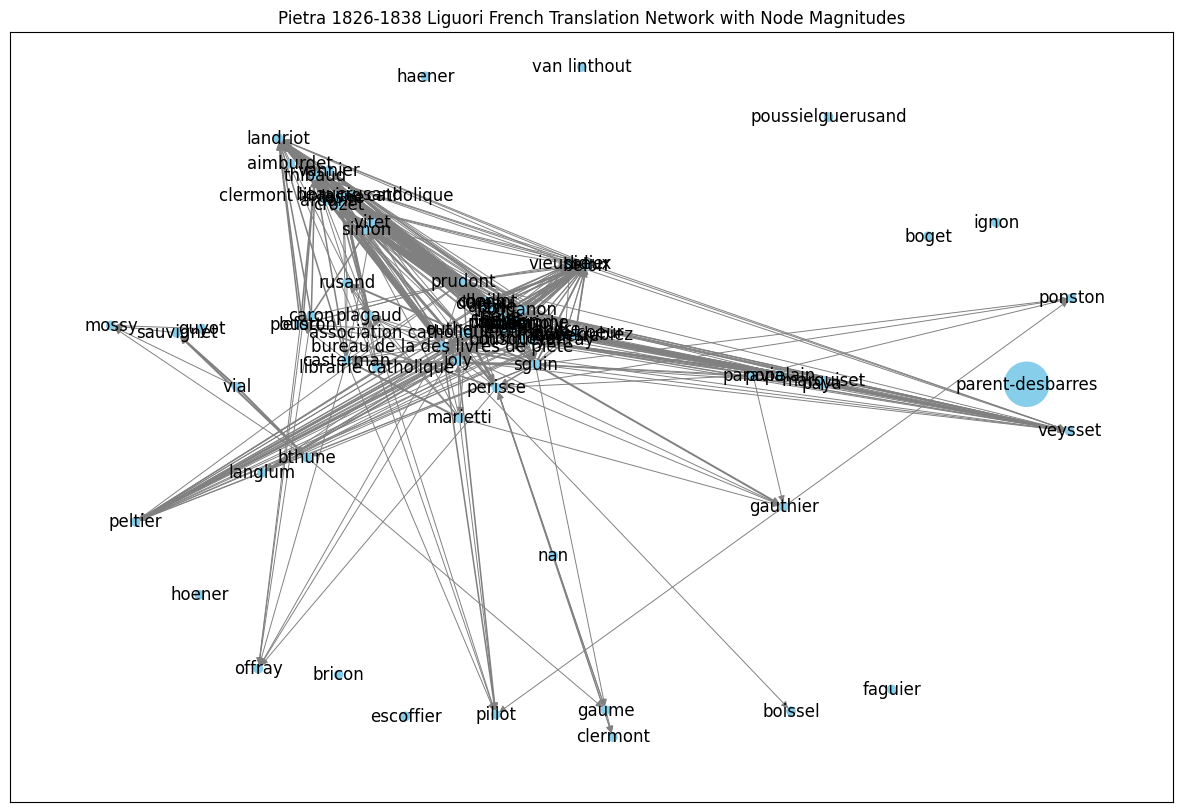

In [17]:

fig, ax = plt.subplots(figsize=(15, 10))

node_sizes = [G_combined.nodes[node].get('magnitude', 1) for node in G_combined.nodes()]

# Scale node sizes for better visualization (adjust scaling factor as needed)
node_sizes = [size * 36 for size in node_sizes]

pos = nx.spring_layout(G_combined)

edge_widths = [np.log(data['weight'] + 1) for _, _, data in G_combined.edges(data=True)]
#edge_widths = [data['weight'] for _, _, data in G_combined.edges(data=True)]

nx.draw_networkx(G_combined, pos, node_size=node_sizes, with_labels=True,
        alpha=1, node_color='skyblue', width=edge_widths, edge_color='gray', arrows=True)

plt.title("Pietra 1826-1838 Liguori French Translation Network with Node Magnitudes")

plt.savefig('PIETRA_Margento_19th_Cent_Liguori_1826-1838_FR_w_Node_Magnitudes.png')

plt.show()

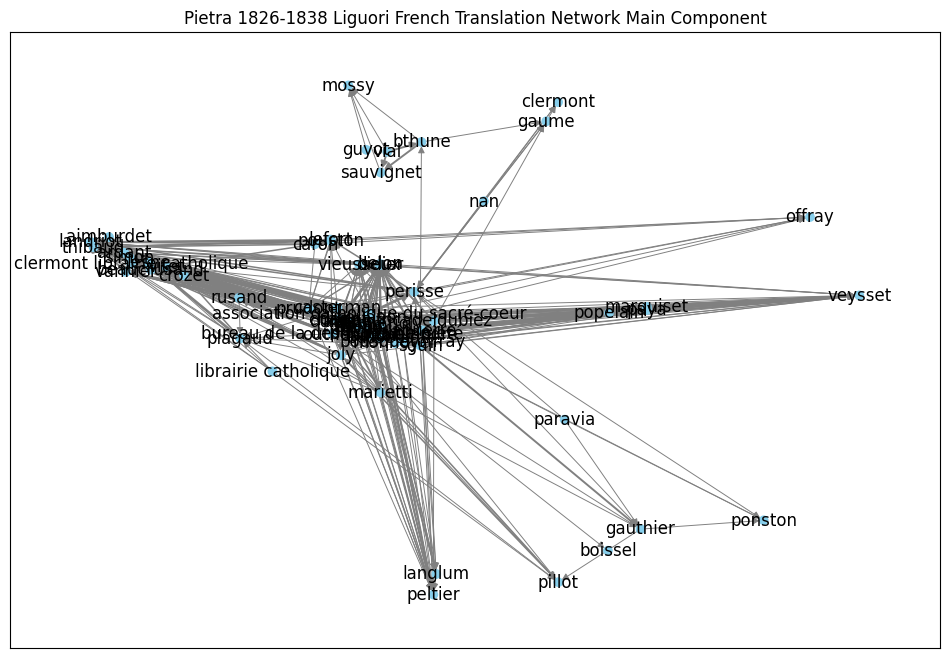

In [47]:

main_component = max(nx.weakly_connected_components(G_combined), key=len)
G_main = G_combined.subgraph(main_component)

node_sizes1 = [G_main.nodes[node].get('magnitude', 1) for node in G_main.nodes()]

node_sizes1 = [size * 36 for size in node_sizes1]

plt.close()

fig, ax = plt.subplots(figsize=(12, 8))

pos = nx.spring_layout(G_main)

edge_widths1 = [np.log(data['weight'] + 1) for _, _, data in G_main.edges(data=True)]

nx.draw_networkx(G_main, pos, node_size=node_sizes1, with_labels=True,
        alpha=1, node_color='skyblue', width=edge_widths1, edge_color='gray', arrows=True)

plt.title("Pietra 1826-1838 Liguori French Translation Network Main Component")

plt.savefig('Pietra_Margento_Liguori_FR_1826-1838_Main_Component.png')

plt.show()

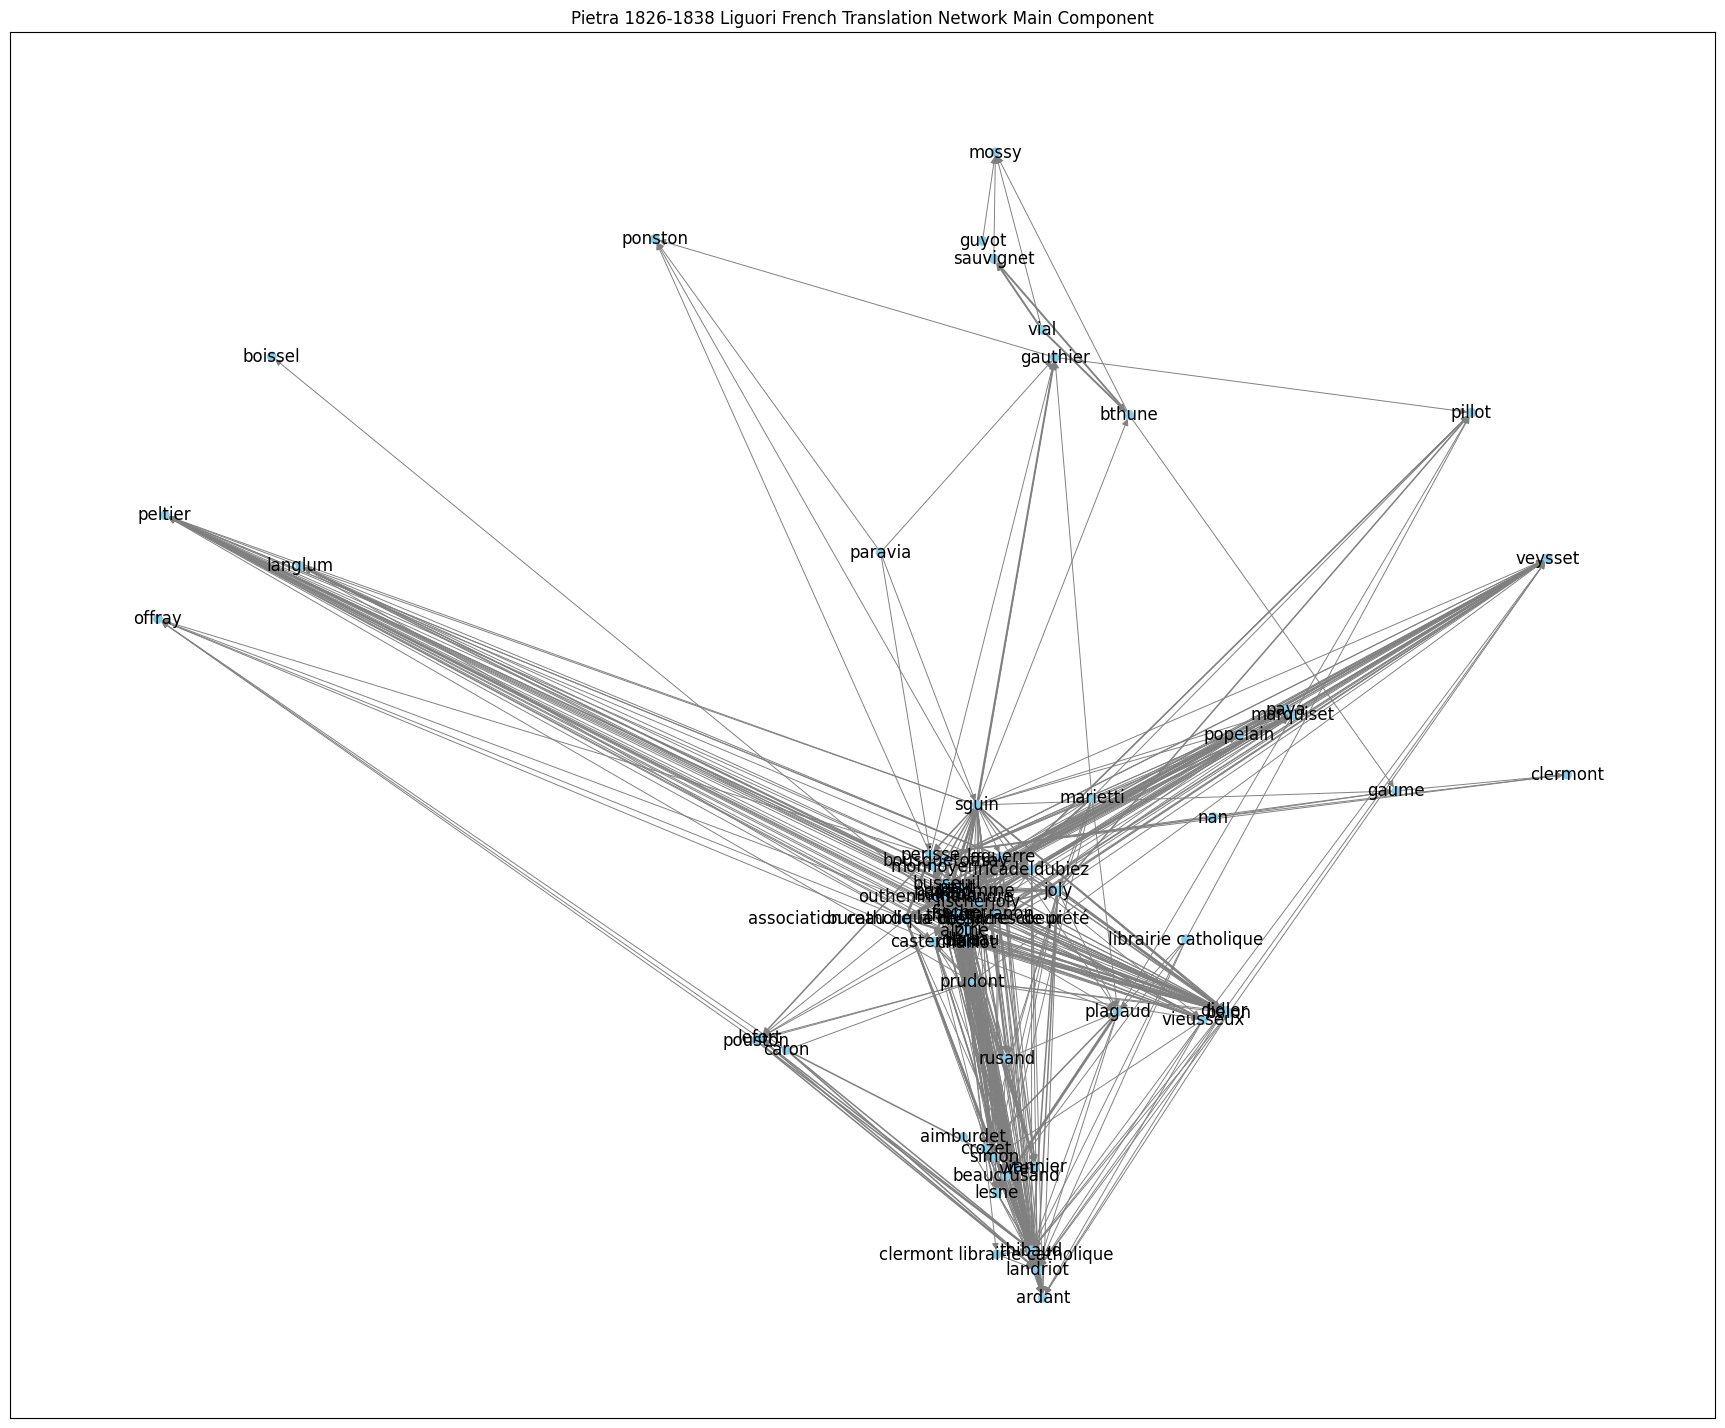

In [48]:
plt.close()

fig, ax = plt.subplots(figsize=(22, 18))

pos = nx.spring_layout(G_main)

edge_widths1 = [np.log(data['weight'] + 1) for _, _, data in G_main.edges(data=True)]

nx.draw_networkx(G_main, pos, node_size=node_sizes1, with_labels=True,
        alpha=1, node_color='skyblue', width=edge_widths1, edge_color='gray', arrows=True)

plt.title("Pietra 1826-1838 Liguori French Translation Network Main Component")

plt.savefig('Pietra_Margento_Liguori_FR_1826-1838_Main_Component1.png')

plt.show()

In [19]:

degree_centrality = nx.degree_centrality(G_combined)
top_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:36]

In [21]:
G_combined_dense_region = G_combined.subgraph(top_nodes)

In [20]:
plt.close()

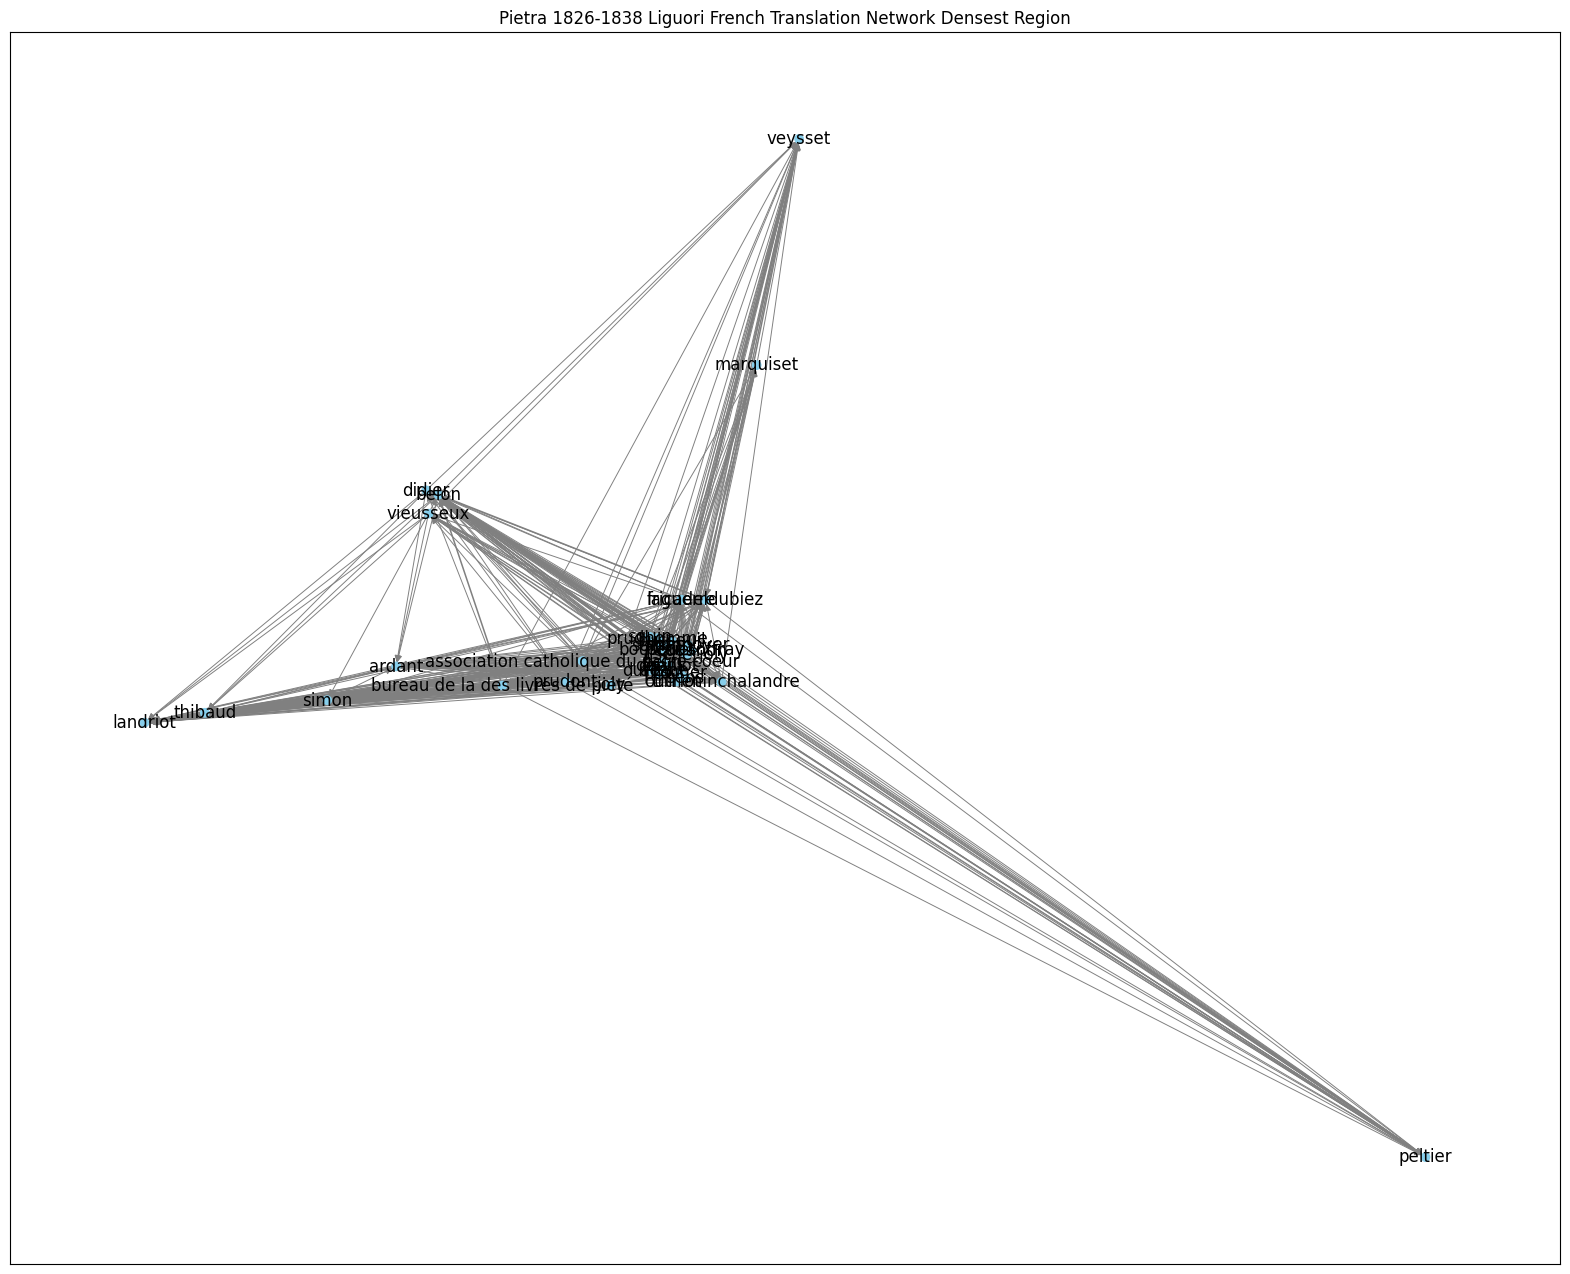

In [25]:

fig, ax = plt.subplots(figsize=(20, 16))

pos = nx.spring_layout(G_combined_dense_region)

node_sizes1 = [G_combined_dense_region[node].get('magnitude', 1) for node in G_combined_dense_region.nodes()]

node_sizes1 = [size * 36 for size in node_sizes1]

edge_widths1 = [np.log(data['weight'] + 1) for _, _, data in G_combined_dense_region.edges(data=True)]

nx.draw_networkx(G_combined_dense_region, pos, node_size=node_sizes1, with_labels=True,
        alpha=1, node_color='skyblue', width=edge_widths1, edge_color='gray', arrows=True)

plt.title("Pietra 1826-1838 Liguori French Translation Network Densest Region")

plt.savefig('Pietra_Margento_1826-1838_Liguori_FR_Densest_Region.png')

plt.show()

In [33]:

degree_centrality = nx.degree_centrality(G_combined)
top_nodes1 = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:28]

In [34]:
G_combined_dense_region1 = G_combined.subgraph(top_nodes1)

In [35]:
plt.close()

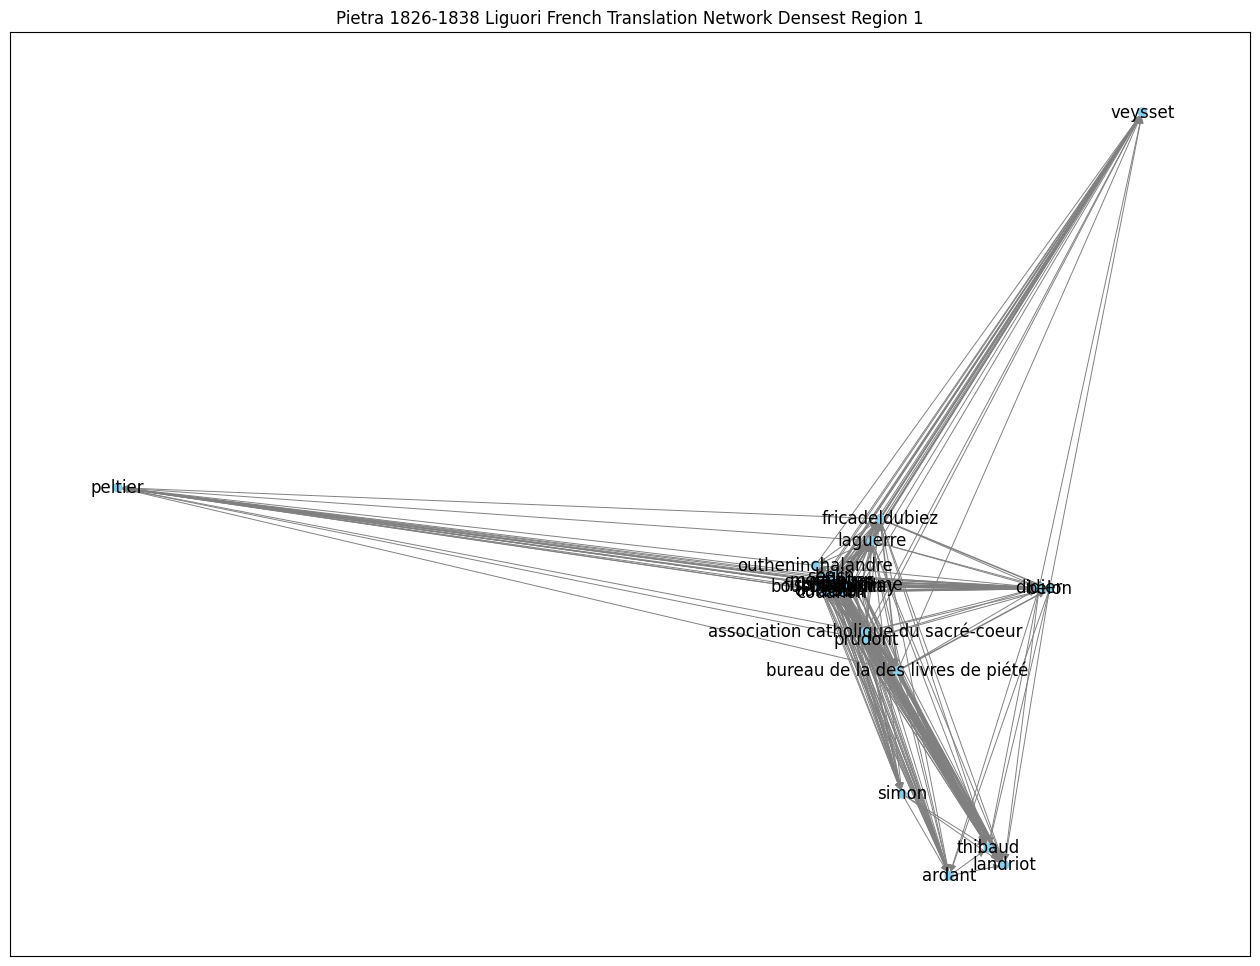

In [39]:


fig, ax = plt.subplots(figsize=(16, 12))

pos = nx.spring_layout(G_combined_dense_region1)

node_sizes2 = [G_combined_dense_region1[node].get('magnitude', 1) for node in G_combined_dense_region1.nodes()]

node_sizes2 = [size * 36 for size in node_sizes2]

edge_widths2 = [np.log(data['weight'] + 1) for _, _, data in G_combined_dense_region1.edges(data=True)]

nx.draw_networkx(G_combined_dense_region1, pos, node_size=node_sizes2, with_labels=True,
        alpha=1, node_color='skyblue', width=edge_widths2, edge_color='gray', arrows=True)

plt.title("Pietra 1826-1838 Liguori French Translation Network Densest Region 1")

plt.savefig('Pietra_Margento_1826-1838_Liguori_FR_Densest_Region_1.png')

plt.show()

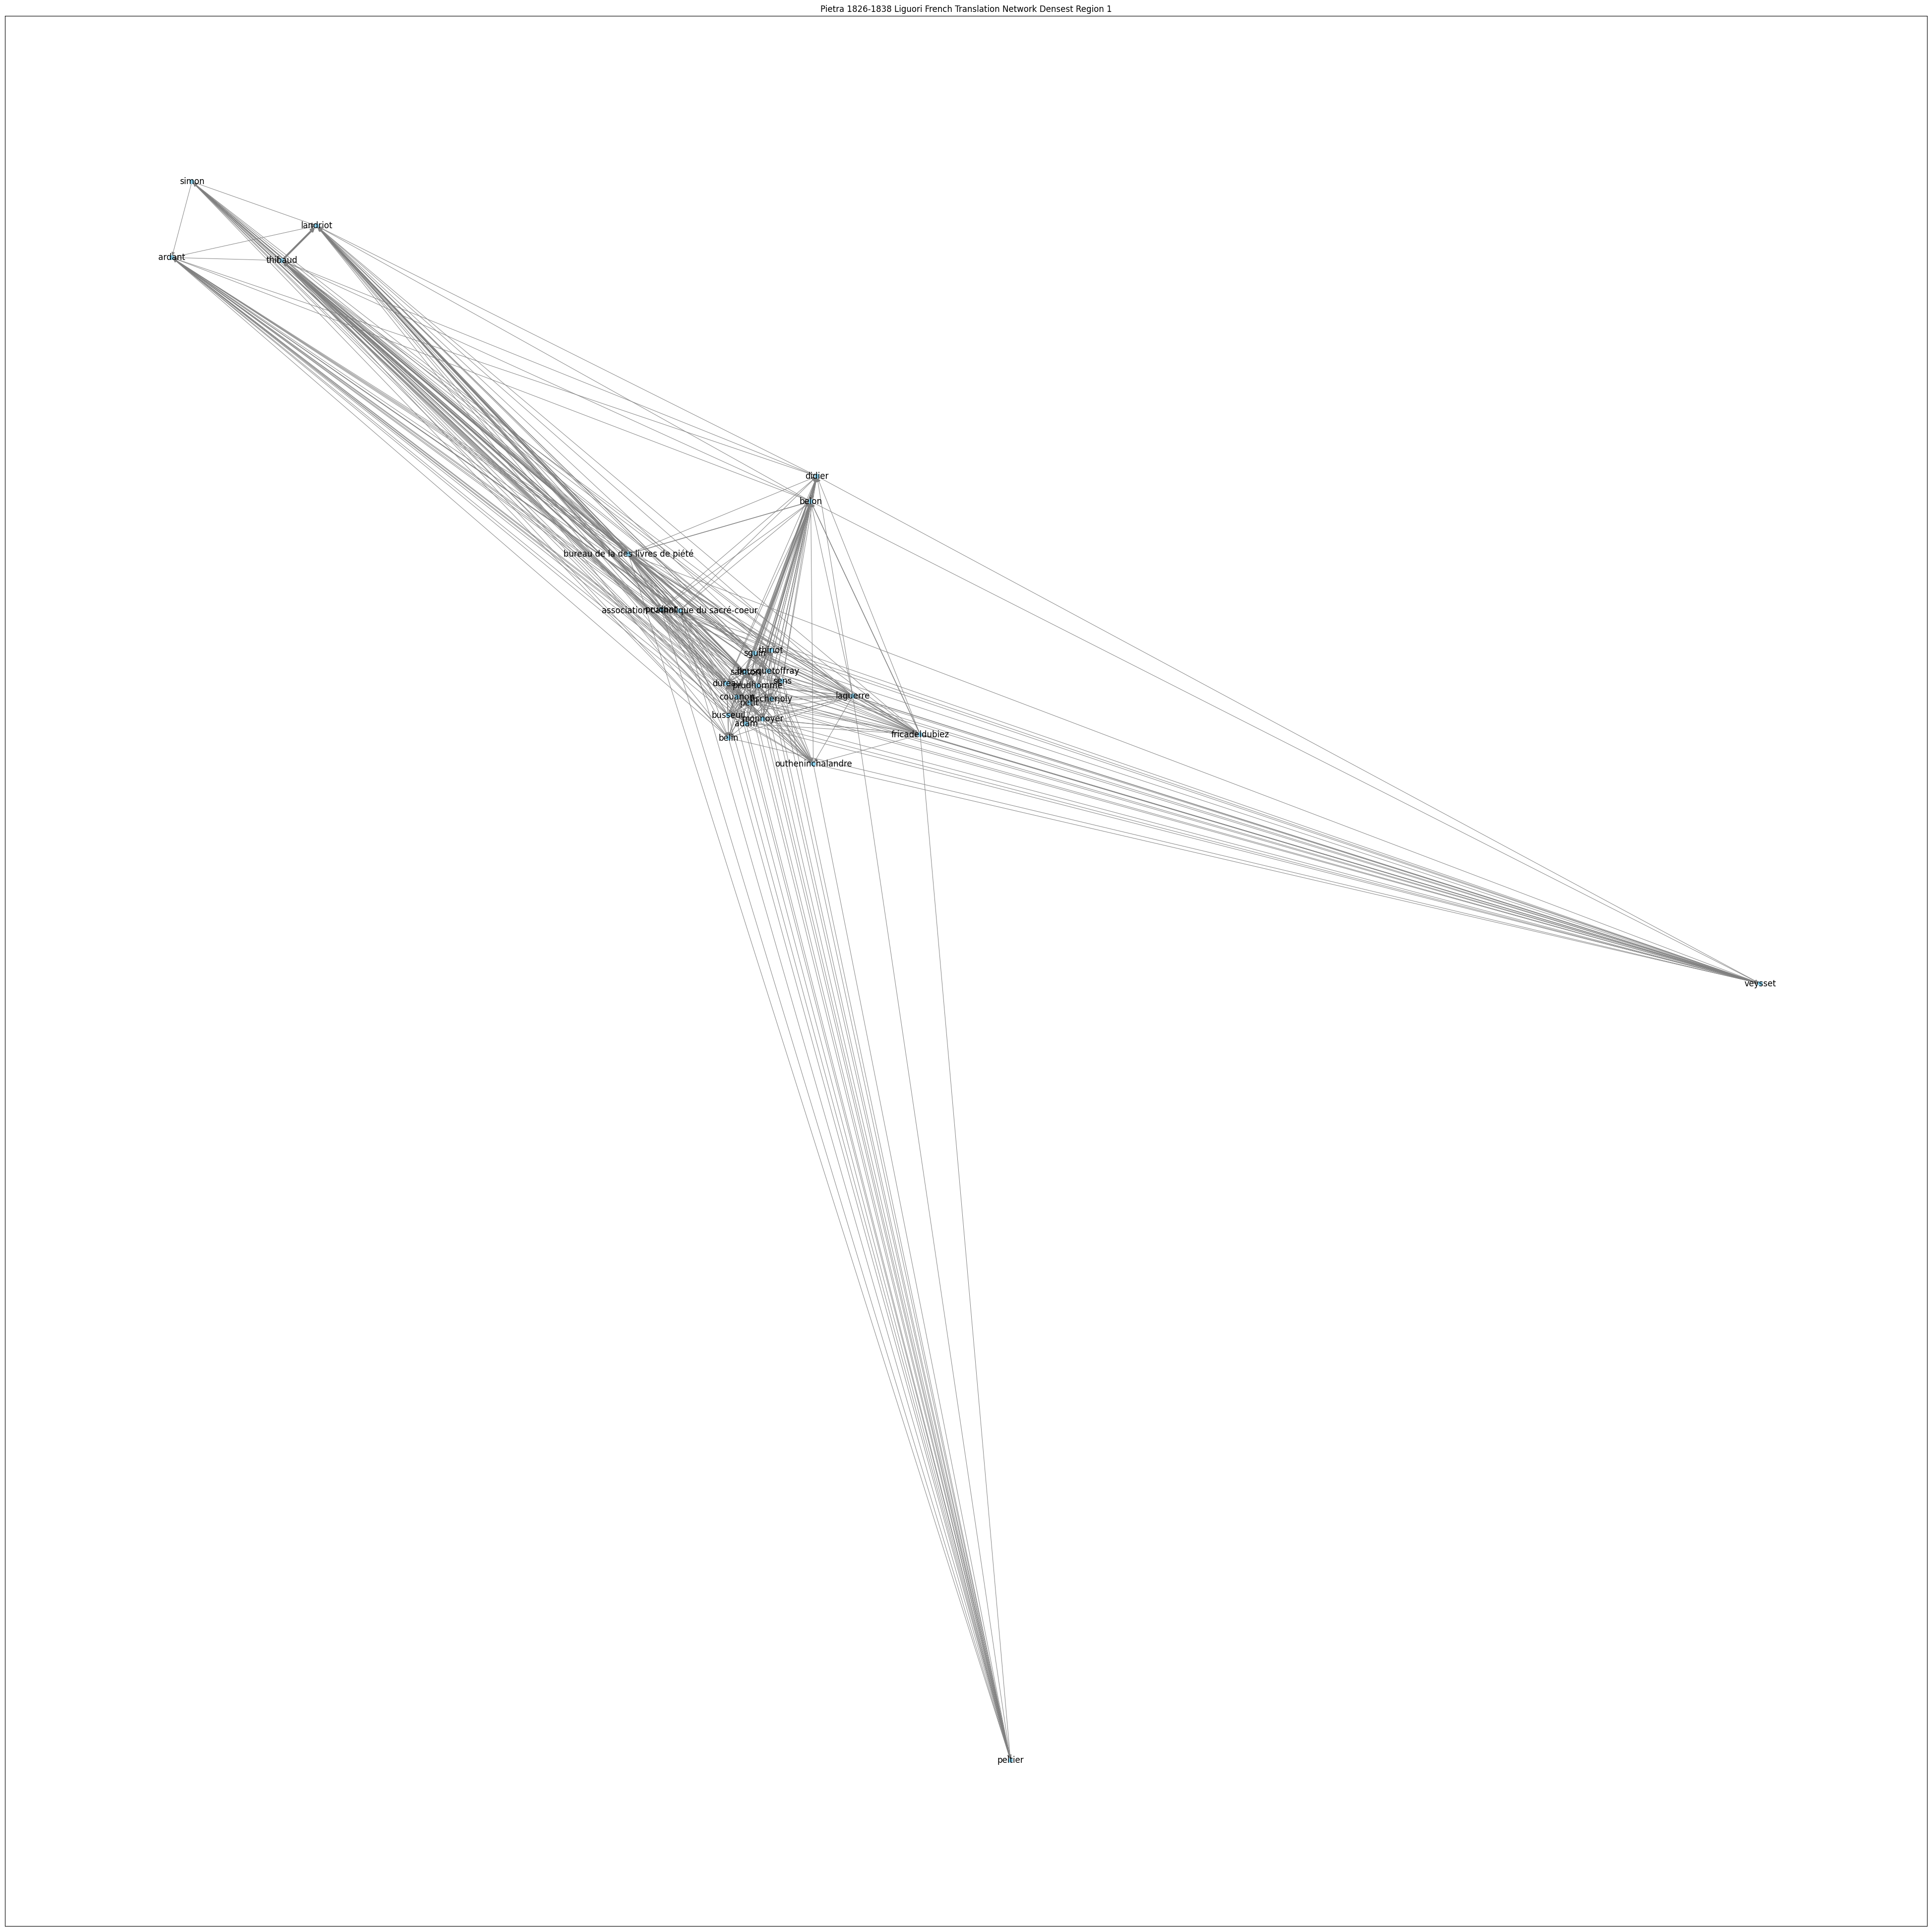

In [46]:



fig, ax = plt.subplots(figsize=(50, 50))

pos = nx.spring_layout(G_combined_dense_region1)

node_sizes2 = [G_combined_dense_region1[node].get('magnitude', 1) for node in G_combined_dense_region1.nodes()]

node_sizes2 = [size * 36 for size in node_sizes2]

edge_widths2 = [np.log(data['weight'] + 1) for _, _, data in G_combined_dense_region1.edges(data=True)]

nx.draw_networkx(G_combined_dense_region1, pos, node_size=node_sizes2, with_labels=True,
        alpha=1, node_color='skyblue', width=edge_widths2, edge_color='gray', arrows=True)

plt.title("Pietra 1826-1838 Liguori French Translation Network Densest Region 1")

plt.savefig('Pietra_Margento_1826-1838_Liguori_FR_Densest_Region_1a.png')

plt.show()